In [ ]:
!pip install fiftyone

In [ ]:
!wandb login

In [1]:
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
import wandb

import sys
from pathlib import Path

project_root = Path("..").resolve()
sys.path.append(str(project_root))
from src import datasets
from src import training
from src import visualization
from src import models


/home/matthias/miniconda3/envs/CompVision/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data 

In [ ]:
# hyperparameters will be the same for all experiments to make them comparable
IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 20

START_LR = 1e-3
END_LR = 1e-6

In [4]:
# load fiftyone dataset from huggingface
dataset = load_from_hub(
    "MatthiasCr/multimodal-shapes-subset", 
    name="multimodal-shapes-subset",
    # fewer workers and greater batch size to hopefully avoid getting rate limited
    num_workers=2,
    batch_size=1000,
    overwrite=True,
)

Loading dataset
Importing samples...
 100% |███████████████| 4000/4000 [49.5ms elapsed, 0s remaining, 80.7K samples/s]   


Now I convert this fiftyone dataset to torch datasets using the already existing tags for the train / val split. I also create dataloaders for train and valid, as well as a separate dataloader to use for predictions on the valid dataset. For all dataloaders with shuffle=True I specify a generator with fixed seed to make the shuffling deterministic.

In [5]:
img_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

train_dataset = datasets.MultimodalDataset(dataset, "train", img_transforms)
val_dataset = datasets.MultimodalDataset(dataset, "val", img_transforms)

# use generator with fixed seed for reproducible shuffling
generator = torch.Generator()
generator.manual_seed(51)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, generator=generator)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# loader to conduct sample predictions
log_loader = DataLoader(val_dataset, batch_size=5, shuffle=True, num_workers=0, generator=generator)

# number of train batches, needed for learning rate scheduling
steps_per_epoch = len(train_dataloader)

## Experiments

In [ ]:
# function that tells the training process how to apply the model on a batch of the dataset
def apply_model(model, batch):
    target = batch[2].to(device)
    inputs_rgb = batch[0].to(device)
    inputs_xyz = batch[1].to(device)
    outputs = model(inputs_rgb, inputs_xyz)
    return outputs, target

In [ ]:
def log_experiment(model, best_model, fusion_type, device, output_name):
    num_params = sum(p.numel() for p in model.parameters())
    optim = Adam(model.parameters(), lr=START_LR)
    scheduler = CosineAnnealingLR(optim, T_max=EPOCHS * steps_per_epoch, eta_min=END_LR)
    loss_func = nn.BCEWithLogitsLoss()

    # init wandb run and log config hyperparameters
    run = training.initWandbRun(
        fusion_type, EPOCHS, BATCH_SIZE, num_params, "Adam", "Cosine Annealing", START_LR, END_LR
    )

    # train and log loss
    train_loss, val_loss = training.train_model(
        model, optim, apply_model, loss_func, EPOCHS, train_dataloader, val_dataloader, device, run, scheduler=scheduler, output_name=output_name
    )

    # load best model
    model_save_path = f"../checkpoints/{output_name}.pt"
    best_model.load_state_dict(torch.load(model_save_path, map_location=device))
    best_model = best_model.to(device)

    # predict on 4 batches of each 5 samples = 20 preditions. Log predictions to wandb
    training.log_predictions(best_model, log_loader, device, run, num_batches=1)
    
    run.finish()
    return train_loss, val_loss

### Late Fusion

wandb: Currently logged in as: matthiascr (matthiascr-hpi-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


All random seeds set to 51 for reproducibility
epoch 0 train loss: 0.7243238914012909
epoch 0 valid loss: 0.6797849188248316 accuracy: 0.7291666666666666
Found and saved better weights for the model
epoch 1 train loss: 0.6225961768627166
epoch 1 valid loss: 0.5804782460133234 accuracy: 0.7265625
Found and saved better weights for the model


learning_rate,█▁
train_loss,█▁
valid_accuracy,█▁
valid_loss,█▁
learning_rate,0.0
total_train_time_sec,9.12613
train_loss,0.6226


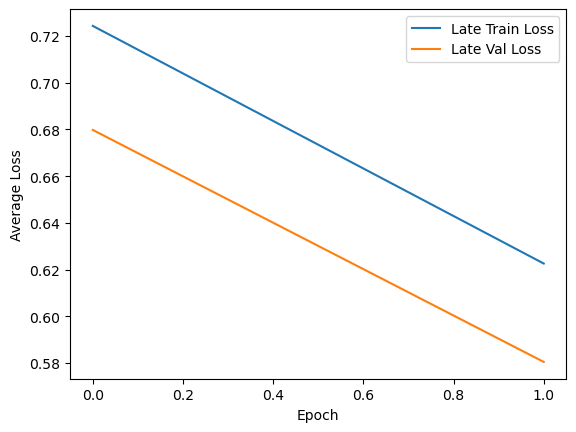

In [ ]:
late_model = models.LateFusionNet().to(device)
late_model_best = models.LateFusionNet().to(device)
late_train_loss, late_val_loss = log_experiment(late_model, late_model_best, "late", device, output_name="late")

visualization.plot_loss(EPOCHS,
    {
        "Late Train Loss": late_train_loss,
        "Late Val Loss": late_val_loss
    }
)

### Intermediate Fusion

In [ ]:
cat_model = models.IntermediateFusionNet(fusion_type="cat").to(device)
cat_model_best = models.IntermediateFusionNet(fusion_type="cat").to(device)
cat_train_loss, cat_val_loss = log_experiment(cat_model, cat_model_best, "intermediate (concatenation)", device, output_name="cat")

add_model = models.IntermediateFusionNet(fusion_type="add").to(device)
add_model_best = models.IntermediateFusionNet(fusion_type="add").to(device)
add_train_loss, add_val_loss = log_experiment(add_model, add_model_best, "intermediate (addition)", device, output_name="add")

had_model = models.IntermediateFusionNet(fusion_type="had").to(device)
had_model_best = models.IntermediateFusionNet(fusion_type="had").to(device)
had_train_loss, had_val_loss = log_experiment(had_model, had_model_best, "intermediate (hadamard)", device, output_name="had")

## Analysis

We can now compare how these models performed on the validation dataset:

In [ ]:
visualization.plot_loss(EPOCHS,
    {
        "Concat Valid Loss": cat_val_loss,
        "Addition Valid Loss": add_val_loss,
        "Hadamard Valid Loss": had_val_loss,
        "Late Valid Loss": late_val_loss
    }
)

We can also visualize and analyze the experiments in WandB:

![](../results/wandb-t3-graphs.png)
![](../results/wandb-t3-table.png)
